(tespy-partload-disection)=

# Disection of the partload efficiency

## Introduction

In [119]:
from heat_pump_models import partload_heat_pump


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


nwk = partload_heat_pump("R290")
nwk.save("R290-design-state")

## Effect of compressor efficiecy

In [120]:
Q_design = -10e3
heat_range = np.linspace(0.5, 1.1, 13) * Q_design
results_heat = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)
T_heat_partload = 5

cd, cp, ev = nwk.get_comp(["condenser", "compressor", "evaporator"])
c11, c12 = nwk.get_conn(["11", "12"])
print(c11.m.val_SI)

c11.set_attr(T=T_heat_partload)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("design")

    results_heat.loc[heat, "compressor-power"] = cp.P.val
    results_heat.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

3.588518958567504


In [121]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=["eta_s"], offdesign=["eta_s_char"])
cp.eta_s_char.char_func.extrapolate = True

# check if the model runs
nwk.solve("offdesign", design_path="R290-design-state")
c11.m.val_SI

3.588518958610542

In [122]:
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="R290-design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

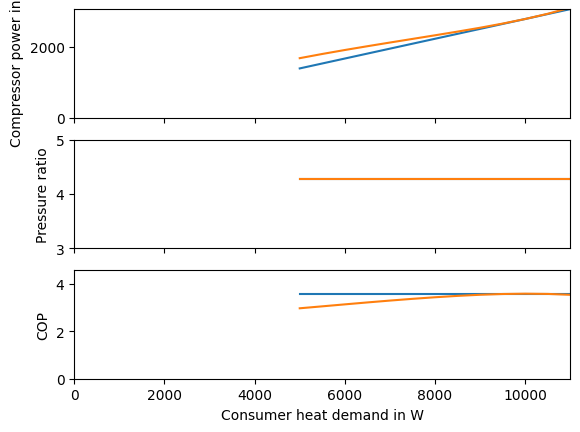

In [123]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([3, 5])
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

## Effect of evaporator heat transfer coefficent

In [124]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=[], offdesign=[], eta_s=cp.eta_s.design, eta_s_char=None)
ev.set_attr(design=["ttd_l"], offdesign=["kA_char"])

# check if the model runs
nwk.solve("offdesign", design_path="R290-design-state")
c11.m.val_SI

ERROR:root:Data container of type ComponentCharacteristics has no attribute is_var.


3.5885189586679878

In [125]:
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="R290-design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

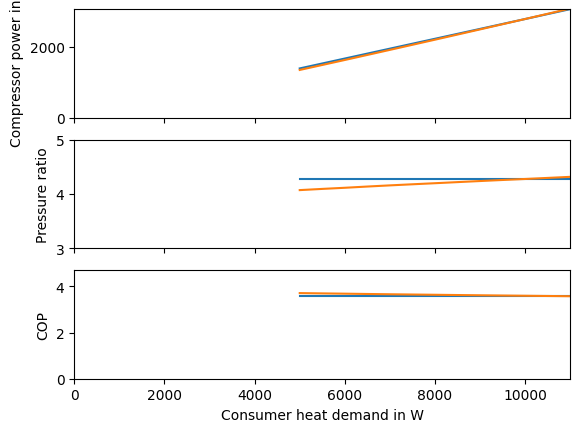

In [126]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([3, 5])
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

## Effect of condenser heat transfer coefficent

In [127]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=[], offdesign=[], eta_s=cp.eta_s.design, eta_s_char=None)
ev.set_attr(design=[], offdesign=[], ttd_l=ev.ttd_l.design, kA_char=None)
cd.set_attr(design=["ttd_u"], offdesign=["kA_char"])

# check if the model runs
nwk.solve("offdesign", design_path="R290-design-state")
c11.m.val_SI

ERROR:root:Data container of type ComponentCharacteristics has no attribute is_var.
ERROR:root:Data container of type GroupedComponentCharacteristics has no attribute is_var.


3.5885189587199426

In [128]:
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="R290-design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

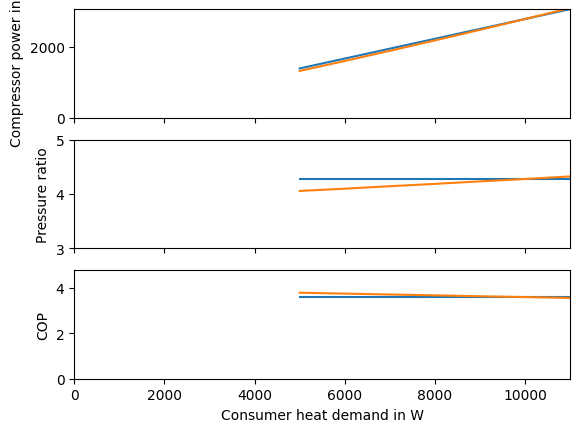

In [129]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([3, 5])
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

## Effect of fixing mass flow

In [130]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=[], offdesign=[], eta_s=cp.eta_s.design, eta_s_char=None)
ev.set_attr(design=[], offdesign=[], ttd_l=ev.ttd_l.design, kA_char=None)
cd.set_attr(design=[], offdesign=[], ttd_u=cd.ttd_u.design, kA_char=None)
c11.set_attr(offdesign=["m"])
c12.set_attr(design=["T"])

# check if the model runs
nwk.solve("offdesign", design_path="R290-design-state")
c11.m.val_SI

ERROR:root:Data container of type ComponentCharacteristics has no attribute is_var.
ERROR:root:Data container of type GroupedComponentCharacteristics has no attribute is_var.
ERROR:root:Data container of type GroupedComponentCharacteristics has no attribute is_var.


3.588518958567504

In [131]:
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="R290-design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

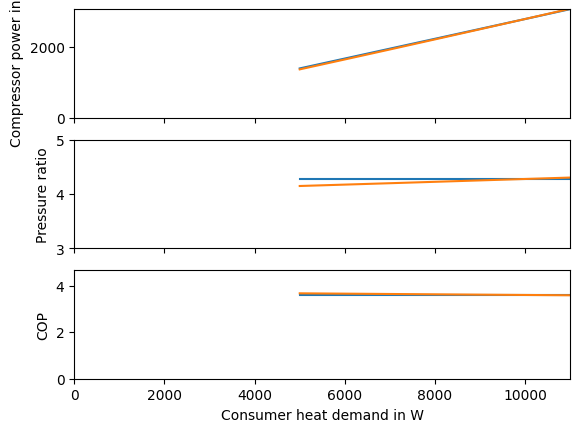

In [132]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([3, 5])
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")